# Hysteresis Processing

The Jackson and Solheid, 2010 paper is a seminal manuscript on forward progress of quantitative hysteresis processing that provides ways for data quality assessment and parameter uncertainty estimates. 

## Workflow for hysteresis processing

1) grid the original data by averaging field step size, and interpolate both the upper and lower branches of the hysteresis loop to the same field steps.
2) perform a linear fit on the original loop data for the high field slope (typically > 80% max field values and < 97% max field value) and subtract the linear fit from all the gridded data points. 
 perform paramagnetic/diamagnetic slope correction on the gridded data
 here we use both the upper and lower branches of the hysteresis loops and invert data points in the third quadrant to the first quadrant for line fitting (ordinary least squares) to estimate the paramagnetic/diamagnetic slope.
 
3) perform linearity test on the girdded original data (high field slope correction not applied)

4) at the same time, centering the high-field slope corrected data, and estiamte the optimal values for field and moment offsets.
 Note that when iterating through different H_offset values on the inverted lower branch, the upper and lower branches will have a H field range mismatch. To account for this, in this code we just use the overlapping region for interpolation and ANOVA statistic.

 Testing with synthetic data shows that the exact offset results from this code is slightly different from that of the IRM database. But the results from this function `hyst_loop_centering` are self-consistent (add synthetic offset + or - results in the same corrected R^2 while the IRM function does not). Given that both functions finds the correct offset values, I use the new function

5) calcualte the Q value to represent the signal/noise ratio (data quality) of the whole loop (ferromagnetic component + paramagnetic (also + diamagnetic component)) after centering. 
6) re-grid the original data with applying the estimated optimal values for field and moment offsets.
7) calcualte H and M errors for each data point.
8) calculate mrh, E_hys, Brh, Bih
9) use the sum of M errors to estimate signal drift correction
10) test saturation of the loop by calculating the FN60, 70, 80 statistics and determine where the loop start to saturate.
11) re-apply high field slope correction to the drift-corrected data
12) calculate the Qf value using the drift-corrected, high-field slope corrected data for the ferromagnetic component quanlity estiamtion.
13) calculate Hcminus, Hcplus, Mrplus, Mrminus, XMr, XHc



## Questions
question: 

difference between loop_errcor and loop_errcor2?

does offset estimate only offset H not M, or does it do both? The paper only talks about offsetting H?

why do we use the same high field slope for correction after centering? Shouldn't we re-fit for the high-field slope afterwards?



## Install and import packages

In [1]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
from scipy.optimize import minimize, brent
from numpy.linalg import svd, lstsq
pd.set_option('display.max_columns', 500)
import ipywidgets as widgets

import matplotlib.pyplot as plt
import math

from IPython.display import display, HTML, clear_output, Javascript 

from loop_grid import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [93]:
ipmag.igrf([2024, 0, 44.975236, -93.233911])

array([2.495534809776402e-01, 7.127596437974265e+01,
       5.492295468757294e+04])

## Import data

To pull data from MagIC, you need to define 3 parameters below:
 - `magic_id`
 - `share_key`
 - `dir_path`
 
### If you are pulling data off of an existing, published dataset on MagIC:
 - look for the MagIC contribution link associated with the dataset
 <img src="example_data/hyst/Images/public_cb_example.png" alt="public_cb_example" width="800" />

 - leave the share key blank `share_key = ''`
 - set the dir_path to where you want the data to be stored
 
### If you are pulling date off of a private MagIC contribution:
 - find the contribution in your private workspace and click on share
  <img src="example_data/hyst/Images/private_cb_example.png" alt="private_cb_example" width="800" />

- set the dir_path to where you want the data to be stored

## Remote Data
You can directly pull data from MagIC by providing the magic_id and share_key. If you do not have a share_key (i.e. a published dataset), leave it as an empty string.


In [5]:
# define these three parameters to match your data
magic_id = '19216'
share_key = ''
dir_path = 'example_data/hyst'

result, magic_file = ipmag.download_magic_from_id(magic_id, directory=dir_path, share_key=share_key)
ipmag.unpack_magic(magic_file, dir_path)
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df
measurements.dropna(axis=1, how='all')

Download successful. File saved to: example_data/hyst/magic_contribution_19216.txt
working on:  'contribution'
1  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/contribution.txt
contribution  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/contribution.txt
working on:  'locations'
8  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/locations.txt
locations  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/locations.txt
working on:  'sites'
18  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/sites.txt
sites  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/sites.txt
working on:  'samples'
92  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/samples.txt
samples  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/samples

,citations,description,dir_dec,dir_inc,experiment,instrument_codes,magn_mass,magn_moment,magn_x,magn_y,magn_z,meas_field_dc,meas_freq,measurement,method_codes,quality,sequence,specimen,standard,susc_chi_mass,timestamp,treat_ac_field,treat_dc_field,treat_dc_field_phi,treat_dc_field_theta,treat_step_num,treat_temp
measurement name,,,,,,,,,,,,,,,,,,,,,,,,,,,
CNF1-1b_hysteresis_1,This study,Mf_BKcor_name=0.138109131594802,NaN,NaN,CNF1-1b_hysteresis,None,1.099976e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_1,LP-HYS,g,1,CNF1-1b,u,NaN,2018,NaN,0.975792,NaN,NaN,1,300.0
CNF1-1b_hysteresis_2,This study,Mf_BKcor_name=0.138394698338928,NaN,NaN,CNF1-1b_hysteresis,None,1.103909e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_2,LP-HYS,g,2,CNF1-1b,u,NaN,2018,NaN,0.970800,NaN,NaN,2,300.0
CNF1-1b_hysteresis_3,This study,Mf_BKcor_name=0.138277046217403,NaN,NaN,CNF1-1b_hysteresis,None,1.104140e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_3,LP-HYS,g,3,CNF1-1b,u,NaN,2018,NaN,0.965802,NaN,NaN,3,300.0
CNF1-1b_hysteresis_4,This study,Mf_BKcor_name=0.138210302091402,NaN,NaN,CNF1-1b_hysteresis,None,1.104880e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_4,LP-HYS,g,4,CNF1-1b,u,NaN,2018,NaN,0.960821,NaN,NaN,4,300.0
CNF1-1b_hysteresis_5,This study,Mf_BKcor_name=0.138028487821671,NaN,NaN,CNF1-1b_hysteresis,None,1.104465e-01,NaN,NaN,NaN,NaN,NaN,NaN,CNF1-1b_hysteresis_5,LP-HYS,g,5,CNF1-1b,u,NaN,2018,NaN,0.955830,NaN,NaN,5,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CNFP6-9d_remanence_7,This study,Description=,204.618,60.8925,CNFP6-9d_remanence,None,6.960000e-07,1.870000e-09,-8.260000e-10,-3.780000e-10,1.630000e-09,NaN,NaN,CNFP6-9d_remanence_7,LP-ARM-AFD,g,45415,CNFP6-9d,u,NaN,2018,0.07,NaN,NaN,NaN,7,NaN
CNFP6-9d_remanence_8,This study,Description=,220.792,34.7740,CNFP6-9d_remanence,None,3.770000e-07,1.010000e-09,-6.290000e-10,-5.430000e-10,5.770000e-10,NaN,NaN,CNFP6-9d_remanence_8,LP-ARM-AFD,g,45416,CNFP6-9d,u,NaN,2018,0.10,NaN,NaN,NaN,8,NaN
CNFP6-9d_remanence_9,This study,Description=,209.009,1.8460,CNFP6-9d_remanence,None,3.550000e-07,9.540000e-10,-8.340000e-10,-4.620000e-10,3.070000e-11,NaN,NaN,CNFP6-9d_remanence_9,LP-ARM-AFD,g,45417,CNFP6-9d,u,NaN,2018,0.12,NaN,NaN,NaN,9,NaN


## Local Data
If the magic file is already saved on your computer, use this instead. Set the file location under dir_path.

In [2]:
# set the dir_path to the directory where the measurements.txt file is located
dir_path = './example_data/hyst/ECMB'

# set the name of the MagIC file
ipmag.unpack_magic('ECMB.TXT', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

working on:  'specimens'
26  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/specimens.txt
specimens  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/specimens.txt
working on:  'samples'
8  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/samples.txt
samples  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/samples.txt
working on:  'sites'
8  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/sites.txt
sites  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/sites.txt
working on:  'locations'
16  records written to file  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/locations.txt
locations  data put in  /Users/yimingzhang/Github/RockmagPy-notebooks/example_data/hyst/ECMB/locations.txt
working on:  'measurements'
8392  records written 

## All of the project data is now stored in the $measurements$ variable

The method codes relevent to hysteresis loops are:
 - `LP-HYS` for regular hysteresis loops
 - `LP-HYS-O` for hysteresis loops as a function of orientation
 - `LP-HYS-T` for hysteresis loops as a function of temperature

In [3]:
# plot the hysteresis loop (only looking for 'LP-HYS')
specimen = rmag.make_hyst_plots2(measurements)

Dropdown(description='Method Code:', options=('LP-HYS',), value='LP-HYS')

Dropdown(description='Specimen:', options=('NED1-5c', 'NED18-2c', 'NED2-8c', 'NED23-8c', 'NED34-6c', 'NED36-8c…

Dropdown(description='Experiment:', options=('IRM-VSM3-LP-HYS-218845', 'IRM-VSM3-LP-BCR-BF-218846'), value='IR…

RadioButtons(description='Plot with:', options=(('matplotlib', False), ('plotly', True)), value=False)

Output()

In [37]:
# extract the specimen specific data
hyst_data, data_type = rmag.extract_hysteresis_data(measurements, specimen.value)

Data Extracted!


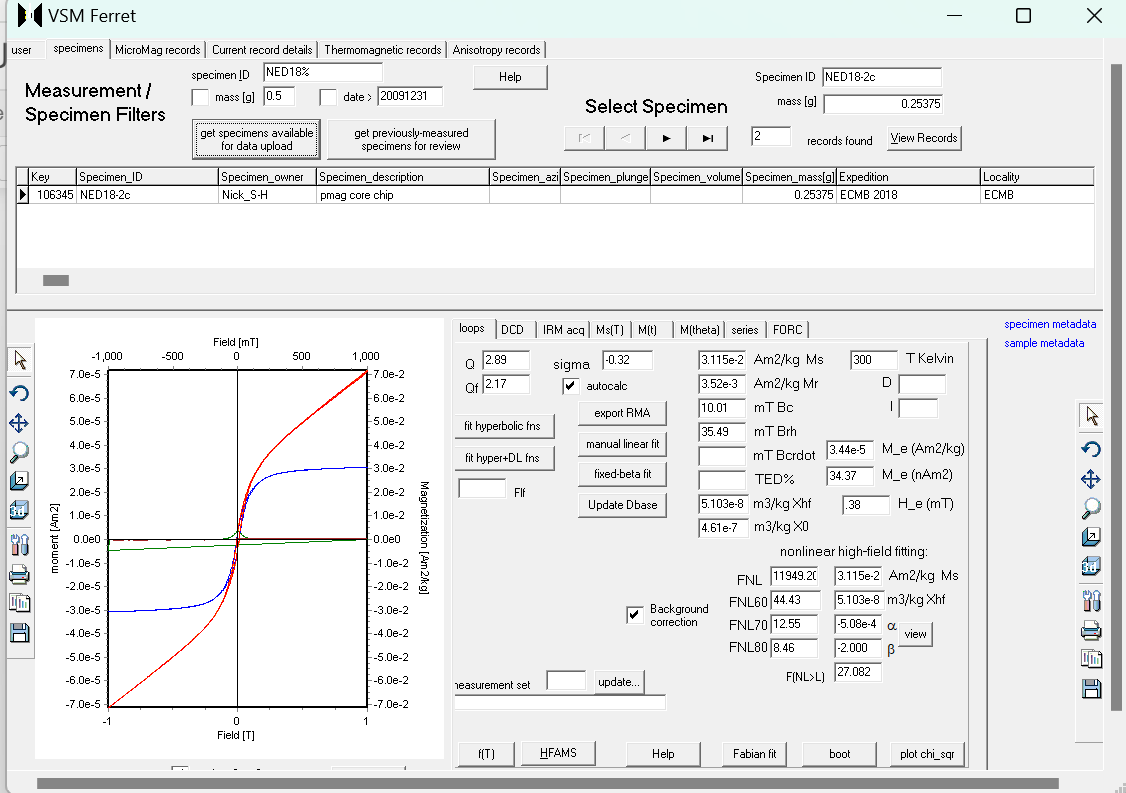

# Loop processing

In [38]:
hyst_data = hyst_data.dropna(axis=1, how='all')
hyst_data

,experiment,instrument_codes,magn_mass,meas_field_dc,meas_temp,measurement,method_codes,quality,specimen,standard,timestamp
measurement name,,,,,,,,,,,
IRM-VSM3-LP-HYS-218847-1,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2827,1.0000,300.0,IRM-VSM3-LP-HYS-218847-1,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00
IRM-VSM3-LP-HYS-218847-2,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2825,0.9989,300.0,IRM-VSM3-LP-HYS-218847-2,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00
IRM-VSM3-LP-HYS-218847-3,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2820,0.9960,300.0,IRM-VSM3-LP-HYS-218847-3,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00
IRM-VSM3-LP-HYS-218847-4,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2813,0.9919,300.0,IRM-VSM3-LP-HYS-218847-4,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00
IRM-VSM3-LP-HYS-218847-5,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2806,0.9873,300.0,IRM-VSM3-LP-HYS-218847-5,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00
...,...,...,...,...,...,...,...,...,...,...,...
IRM-VSM3-LP-HYS-218847-798,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2760,0.9728,300.0,IRM-VSM3-LP-HYS-218847-798,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00
IRM-VSM3-LP-HYS-218847-799,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2768,0.9777,300.0,IRM-VSM3-LP-HYS-218847-799,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00
IRM-VSM3-LP-HYS-218847-800,IRM-VSM3-LP-HYS-218847,IRM-VSM3,0.2777,0.9828,300.0,IRM-VSM3-LP-HYS-218847-800,LP-HYS,g,NED18-2c,u,2020:01:06:14:08:00.00


1000
Optimal H_offset: -0.0017917917917917928
Hoffset: 0.000375559510442054 Moffset: 0.0001339482508611163 SNR: 0.0013177565703372418


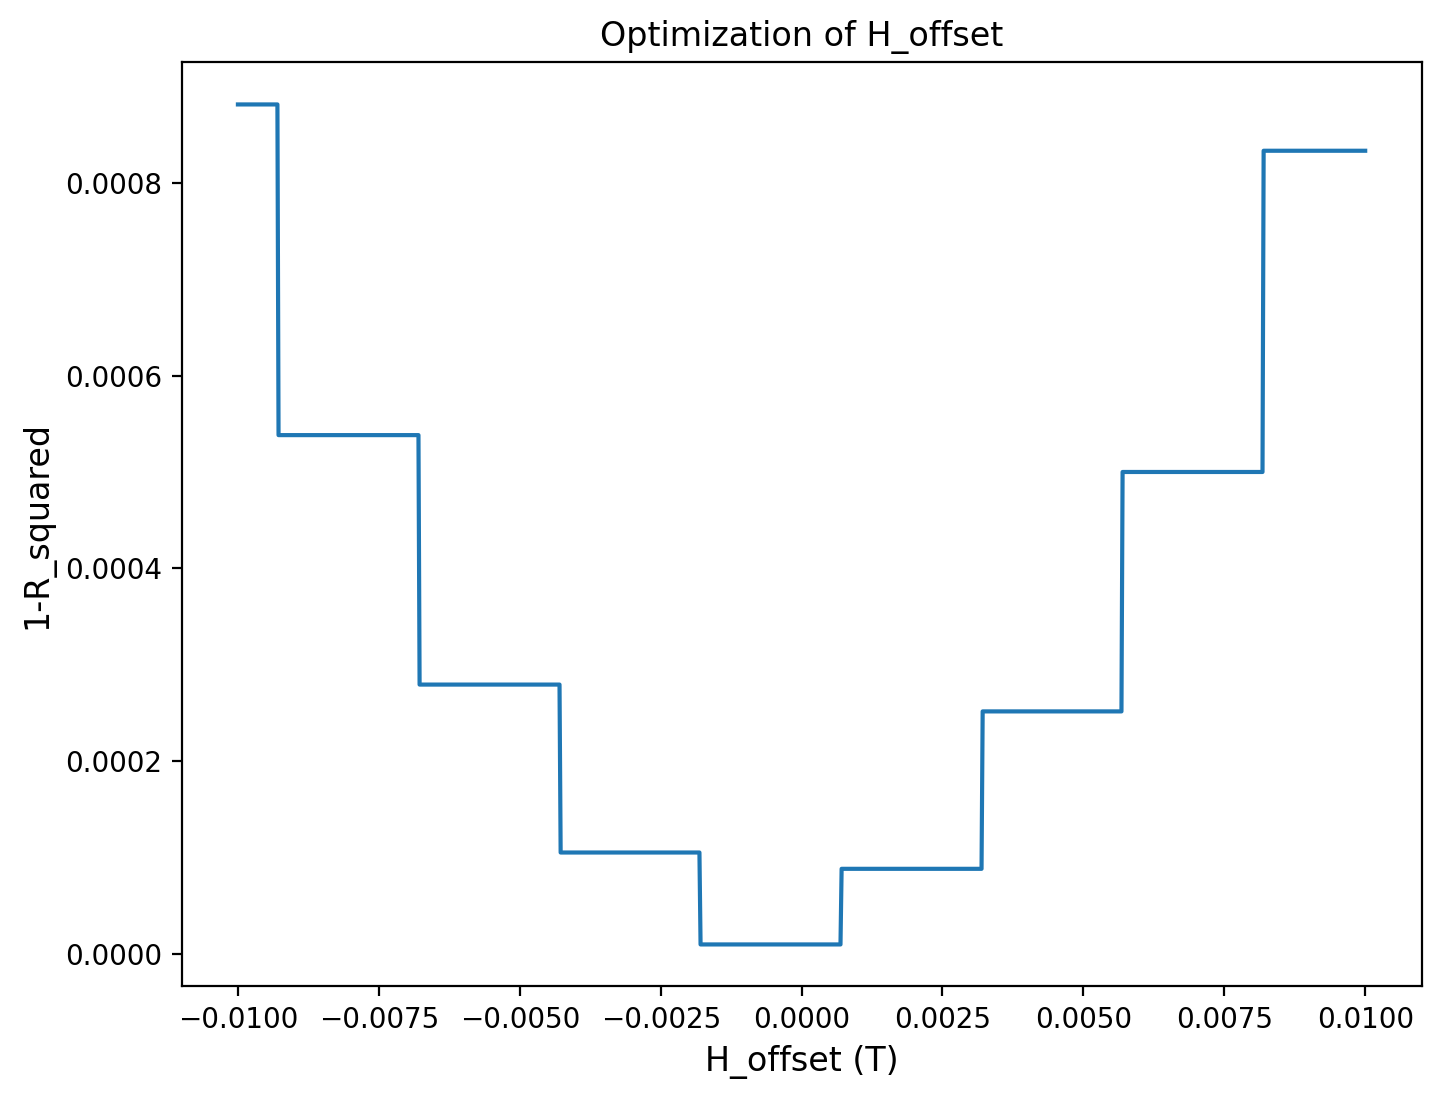

In [114]:
def plot_hysteresis_loop(ax, field, magnetization, **kwargs):
    '''
    function to plot a hysteresis loop

    Parameters
    ----------
    ax : matplotlib axis object
        axis object to plot the data
    field : numpy array or list
        hysteresis loop field values
    magnetization : numpy array or list
        hysteresis loop magnetization values
    **kwargs : keyword arguments
        additional keyword arguments to pass to the plot function

    Returns
    -------
    ax : matplotlib axis object
        axis object with the hysteresis loop plotted
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'

    ax.plot(field, magnetization, 'o-', markersize=2, **kwargs)
    ax.set_xlabel('Field (T)', fontsize=12)
    ax.set_ylabel('Magnetization (A/m)', fontsize=12)
    ax.set_title('Hysteresis Loop', fontsize=12)
    return ax

def split_hysteresis_loop(field, magnetization):
    '''
    function to split a hysteresis loop into upper and lower branches
        by the change of sign in the applied field gradient

    Parameters
    ----------
    field : numpy array or list
        hysteresis loop field values
    magnetization : numpy array or list
        hysteresis loop magnetization values

    Returns
    -------
    upper_branch : tuple
        tuple of field and magnetization values for the upper branch
    lower_branch : tuple
        tuple of field and magnetization values for the lower branch
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'

    # identify loop turning point by change in sign of the field difference
    # split the data into upper and lower branches
    field_gradient = np.gradient(field)
    # There should just be one turning point in the field gradient
    turning_points = np.where(np.diff(np.sign(field_gradient)))[0]
    if len(turning_points) > 1:
        raise ValueError('More than one turning point found in the gradient of the applied field')
    turning_point = turning_points[0]
    upper_branch = [field[:turning_point+1], magnetization[:turning_point+1]]
    # sort the upper branch in reverse order
    upper_branch = [field[:turning_point+1][::-1], magnetization[:turning_point+1][::-1]]
    lower_branch = [field[turning_point+1:], magnetization[turning_point+1:]]
    
    return upper_branch, lower_branch

def grid_hysteresis_loop(field, magnetization):
    '''
    function to grid a hysteresis loop into a regular grid
        with grid intervals equal to the average field step size calculated from the data

    Parameters
    ----------
    field : numpy array or list
        hysteresis loop field values
    magnetization : numpy array or list
        hysteresis loop magnetization values

    Returns
    -------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'

    # calculate the average field step size
    field_step = np.mean(np.abs(np.diff(field)))

    # grid the hysteresis loop
    upper_field = np.arange(np.max(field), np.min(field), -field_step)
    lower_field = upper_field[::-1]
    grid_field = np.concatenate([upper_field, lower_field])
    upper_branch, lower_branch = split_hysteresis_loop(field, magnetization)
    upper_branch_itp = np.interp(upper_field, upper_branch[0], upper_branch[1])
    lower_branch_itp = np.interp(lower_field, lower_branch[0], lower_branch[1])
    grid_magnetization = np.concatenate([upper_branch_itp, lower_branch_itp])

    return grid_field, grid_magnetization

def linear_HF_fit(field, magnetization, HF_cutoff=0.8):
    '''
    function to fit a linear function to the high field portion of a hysteresis loop

    Parameters
    ----------
    field : numpy array or list
        raw hysteresis loop field values
    magnetization : numpy array or list
        raw hysteresis loop magnetization values

    Returns
    -------
    slope : float
        slope of the linear fit
        can be interpreted to be the paramagnetic/diamagnetic susceptibility
    intercept : float
        y-intercept of the linear fit
        can be interpreted to be the saturation magnetization of the ferromagnetic component
    '''
    assert len(field) == len(magnetization), 'Field and magnetization arrays must be the same length'
    assert HF_cutoff > 0 and HF_cutoff < 1, 'Portion must be between 0 and 1'

    # adopting IRM's max field cutoff at 97% of the max field
    max_field_cutoff = 0.97
    
    field = np.array(field)
    magnetization = np.array(magnetization)

    # filter for the high field portion of each branch

    high_field_index = np.where((np.abs(field) >= HF_cutoff*np.max(np.abs(field))) & (np.abs(field) <= max_field_cutoff*np.max(np.abs(field))))[0]

    # invert points in the third quadrant to the first
    high_field = np.abs(field[high_field_index])
    high_field_magnetization = np.abs(magnetization[high_field_index])

    # the slope would be the paramagnetic/diamagnetic susceptibility
    # the y-intercept would be the Ms value (saturation magnetization of the ferromagnetic component)
    slope, intercept = np.polyfit(high_field, high_field_magnetization, 1)
    
    return slope, intercept

def hyst_slope_correction(grid_field, grid_magnetization, slope):
    '''
    function for subtracting the paramagnetic/diamagnetic slope from a hysteresis loop
         the input should be gridded field and magnetization values

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values
    slope : float
        slope of the linear fit

    Returns
    -------
    grid_magnetization_ferro: numpy array
        corrected ferromagnetic component of the magnetization
    '''
    assert len(grid_field) == len(grid_magnetization), 'Field and magnetization arrays must be the same length'
    
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    grid_magnetization_ferro = grid_magnetization - slope*grid_field

    return grid_magnetization_ferro

def ANOVA(xs, ys):
    '''
    ANOVA statistics for linear regression
    
    Parameters
    ----------
    xs : numpy array
        x values
    ys : numpy array
        y values

    Returns
    -------
    results : dict
        dictionary of the results of the ANOVA calculation
        and intermediate statistics for the ANOVA calculation

    '''

    xs = np.array(xs)
    ys = np.array(ys)

    ys_mean = np.mean(ys)

    # fit the gridded data by a straight line
    slope, intercept = np.polyfit(xs, ys, 1)

    # AVOVA calculation
    # total sum of squares for the dependent variable (magnetization)
    SST = np.sum((ys - ys_mean) ** 2)

    # sum of squares due to regression
    SSR = np.sum((slope * xs + intercept - ys_mean) ** 2)
    
    # the remaining unexplained variation (noise and lack of fit)
    SSD = SST-SSR

    R_squared = SSR/SST

    results = {'slope':slope,
                'intercept':intercept,
                'SST':SST,
                'SSR':SSR,
                'SSD':SSD,
                'R_squared': R_squared}
    
    return results

def hyst_linearity_test(grid_field, grid_magnetization):
    '''
    function for testing the linearity of a hysteresis loop

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values

    Returns
    -------
    results : dict
        dictionary of the results of the linearity test
        and intermediate statistics for the ANOVA calculation

    '''

    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)

    anova_results = ANOVA(grid_field, grid_magnetization)

    # fit the gridded data by a straight line
    slope, intercept = anova_results['slope'], anova_results['intercept']

    # AVOVA calculation
    # total sum of squares for the dependent variable (magnetization)
    SST = anova_results['SST']

    # sum of squares due to regression
    SSR = anova_results['SSR']
    
    # the remaining unexplained variation (noise and lack of fit)
    SSD = anova_results['SSD']

    R_squared = SSR/SST

    # invert the lower branch to match the upper branch
    # and calculate the differences between the upper and the inverted lower branch
    # for any loop shifts and drift that are due to noise alone
    SSPE = np.sum((upper_branch[1] - (-lower_branch[1][::-1])) ** 2)  / 2

    # calculate the lack of fit statistic
    SSLF = SSD - SSPE

    # mean square pure error
    MSPE = 2 * SSPE / len(grid_field)

    # mean square error due to lack of fit
    MSLF = SSLF / (len(grid_field)/2 - 2)

    # mean squares due to regression
    MSR = SSR / (len(grid_field) - 2)

    # mean squares due to noise
    MSD = SSD / (len(grid_field) - 2)

    # square mean pure error
    MSPE = SSPE / (len(grid_field) / 2)

    # square mean lack of fit
    MSLF = SSLF / (len(grid_field) / 2 - 2)

    # F-ratio for the linear component
    FL = MSR / MSD

    # F-ratio for the non-linear component
    FNL = MSLF / MSPE

    results = {'SST':SST, 
            'SSR':SSR,
            'SSD':SSD,
            'R_squared': R_squared, 
            'SSPE':SSPE,
            'SSLF':SSLF, 
            'MSPE':MSPE,
            'MSLF':MSLF,
            'MSR':MSR, 
            'MSD':MSD, 
            'MSPE':MSPE, 
            'MSLF':MSLF, 
            'FL':FL, 'FNL':FNL, 
            'slope':slope, 'intercept':intercept}

    return results


def hyst_loop_centering(grid_field, grid_magnetization):
    '''
    function for finding the optimum applied field offset value for the lower branch of a hysteresis loop
        that results in the best linear fit between the upper branch and the inverted and offsetted lower branch

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values

    Returns
    -------
    opt_H_offset : float
        optimized applied field offset value for the loop
    opt_M_offset : float
        calculated magnetization offset value for the loop based on the optimized applied field offset
        (intercept of the fitted line using the upper branch and the inverted and optimally offsetted lower branch)
    R_squared : float
        R-squared value of the linear fit between the upper branch and the inverted and offsetted lower branch

    '''
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    # split the hysteresis loop into upper and lower branches
    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)
    lower_branch_inverted = [-lower_branch[0][::-1], -lower_branch[1][::-1]]
    global opt_M_offset
    # find the optimized H_offset that minimizes the correlation between M(H) and -M_inv (-H, H_offset)
    def calc_H_offset(H_offset):
        global opt_M_offset
        # shift the lower branch by the H_offset
        lower_branch_inverted_shifted = [lower_branch_inverted[0] + 2*H_offset, lower_branch_inverted[1]]

        # find the max of the min of the two branches and the min of the max of the two branches
        # to find the overlapping region
        upper_bound = np.min([np.max(upper_branch[0]), np.max(lower_branch_inverted_shifted[0])])
        lower_bound = np.max([np.min(upper_branch[0]), np.min(lower_branch_inverted_shifted[0])])

        # find the overlapping region
        upper_overlapping_idx = np.where((upper_branch[0] >= lower_bound) & (upper_branch[0] <= upper_bound))
        upper_branch_overlapping = [upper_branch[0][upper_overlapping_idx], upper_branch[1][upper_overlapping_idx]]
        lower_overlapping_idx = np.where((lower_branch_inverted_shifted[0] >= lower_bound) & (lower_branch_inverted_shifted[0] <= upper_bound))
        lower_branch_overlapping = [lower_branch_inverted_shifted[0][lower_overlapping_idx], lower_branch_inverted_shifted[1][lower_overlapping_idx]]

        H_offset_anova = ANOVA(upper_branch_overlapping[1], lower_branch_overlapping[1])
        opt_M_offset = H_offset_anova['intercept']/2
        # correlation_coefficient = np.corrcoef(upper_branch[1], lower_branch_itp)
        # R_squared = correlation_coefficient[0,1] ** 2
        return 1-H_offset_anova['R_squared']

    opt_H_offset, inv_R_squared, _, _ = brent(calc_H_offset, brack=(-np.max(grid_field)/2, 0, np.max(grid_field)/2), tol=1e-6, full_output=True)
    R_squared = 1-inv_R_squared
    # signal to noise ratio
    M_sn = 1/(1-R_squared)
    Q = np.log10(M_sn)
    return opt_H_offset, opt_M_offset, R_squared, M_sn, Q

def hyst_loop_centering_plot(grid_field, grid_magnetization):
    '''
    function for finding the optimum applied field offset value for the lower branch of a hysteresis loop
        that results in the best linear fit between the upper branch and the inverted and offsetted lower branch

    Parameters
    ----------
    grid_field : numpy array
        gridded field values
    grid_magnetization : numpy array
        gridded magnetization values

    Returns
    -------
    opt_H_offset : float
        optimized applied field offset value for the loop
    opt_M_offset : float
        calculated magnetization offset value for the loop based on the optimized applied field offset
        (intercept of the fitted line using the upper branch and the inverted and optimally offsetted lower branch)
    R_squared : float
        R-squared value of the linear fit between the upper branch and the inverted and offsetted lower branch

    '''
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    # split the hysteresis loop into upper and lower branches
    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)
    lower_branch_inverted = [-lower_branch[0][::-1], -lower_branch[1][::-1]]
    global opt_M_offset
    # find the optimized H_offset that minimizes the correlation between M(H) and -M_inv (-H, H_offset)
    def calc_H_offset(H_offset):
        global opt_M_offset
        # shift the lower branch by the H_offset
        lower_branch_inverted_shifted = [lower_branch_inverted[0] - 2*H_offset, lower_branch_inverted[1]]

        # find the max of the min of the two branches and the min of the max of the two branches
        # to find the overlapping region
        upper_bound = np.min([np.max(upper_branch[0]), np.max(lower_branch_inverted_shifted[0])])
        lower_bound = np.max([np.min(upper_branch[0]), np.min(lower_branch_inverted_shifted[0])])

        # find the overlapping region
        upper_overlapping_idx = np.where((upper_branch[0] >= lower_bound) & (upper_branch[0] <= upper_bound))
        upper_branch_overlapping = [upper_branch[0][upper_overlapping_idx], upper_branch[1][upper_overlapping_idx]]
        lower_overlapping_idx = np.where((lower_branch_inverted_shifted[0] >= lower_bound) & (lower_branch_inverted_shifted[0] <= upper_bound))
        lower_branch_overlapping = [lower_branch_inverted_shifted[0][lower_overlapping_idx], lower_branch_inverted_shifted[1][lower_overlapping_idx]]

        H_offset_anova = ANOVA(upper_branch_overlapping[1], lower_branch_overlapping[1])
        opt_M_offset = H_offset_anova['intercept']/2
        # correlation_coefficient = np.corrcoef(upper_branch[1], lower_branch_itp)
        # R_squared = correlation_coefficient[0,1] ** 2
        return 1-H_offset_anova['R_squared']

    fig, ax = plt.subplots(figsize=(8,6))
    inv_R_squared_list = []
    H_offset_list = np.linspace(-0.01, 0.01, 100)
    print(len(H_offset_list))
    for H_offset in H_offset_list:
        inv_R_squared_list.append(calc_H_offset(H_offset))
    ax.plot(H_offset_list, inv_R_squared_list)
    ax.set_xlabel('H_offset (T)', fontsize=12)
    ax.set_ylabel('1-R_squared', fontsize=12)
    ax.set_title('Optimization of H_offset', fontsize=12)
    print('Optimal H_offset:', H_offset_list[np.argmin(inv_R_squared_list)])
    return 

def calc_Mrh_Mih(grid_field, grid_magnetization, H_offset, M_offset):
    # calculate Mrh bu subtracting the upper and lower branches of a hysterisis loop
    grid_field = np.array(grid_field)
    grid_magnetization = np.array(grid_magnetization)

    grid_field = grid_field - H_offset
    grid_magnetization = grid_magnetization - M_offset

    upper_branch, lower_branch = split_hysteresis_loop(grid_field, grid_magnetization)
    Mrh = (upper_branch[1] - lower_branch[1])/2
    Mih = (upper_branch[1] + lower_branch[1])/2

    err_M = upper_branch[1] - lower_branch[1][::-1]

    # calculate area between the upper and lower branches
    # this is the error curve
    err = np.trapz(err_M, upper_branch[0])
    return Mrh, Mih, err


def hyst_loop_saturation_test(grid_field, grid_magnetization):
    '''
    function for testing the saturation of a hysteresis loop
        which is based on the testing of linearity of the loop in field ranges of 60%, 70%, and 80% of the maximum field (<97%)
    '''
    # set default max field cutoff at 97% of the max field
    max_field_cutoff = 0.97 

    # get data between 60% and 97% of the max field
    range_60 = np.where((np.abs(grid_field) >= 0.6*np.max(np.abs(grid_field))) & (np.abs(grid_field) <= max_field_cutoff*np.max(np.abs(grid_field))))
    range_70 = np.where((np.abs(grid_field) >= 0.7*np.max(np.abs(grid_field))) & (np.abs(grid_field) <= max_field_cutoff*np.max(np.abs(grid_field))))
    range_80 = np.where((np.abs(grid_field) >= 0.8*np.max(np.abs(grid_field))) & (np.abs(grid_field) <= max_field_cutoff*np.max(np.abs(grid_field))))



    FNS60 = 0.0
    FNS70 = 0.0
    FNS80 = 0.0
    MS = 0.0
    Xhf = 0.0

    for j in range(1, 4):
        xarr = []
        yarr = []
        if j == 1:
            xcutoff1 = 0.6 * loop_fields[0]
        elif j == 2:
            xcutoff1 = 0.7 * loop_fields[0]
        elif j == 3:
            xcutoff1 = 0.8 * loop_fields[0]

        n = 0   #n = 0
        bmax = 0.0

        for i in range(n_looppoints):
            if abs(loop_fields[i]) >= xcutoff1 and abs(loop_fields[i]) <= xcutoff2:
                #n += 1
                xarr.append(abs(loop_fields[i]))
                yarr.append(np.sign(loop_fields[i]) * loop_moments[i])
                n += 1

            if abs(loop_fields[i]) > bmax:
                bmax = abs(loop_fields[i])

        #for idx, val in enumerate(yarr):
            #print(f"Index {idx}: {val}")


        intercept, slope, r2 = linefit2(n, xarr, yarr)   #intercept, slope, r2 = linefit2(n, np.array(x), np.array(y))

        k = n // 2
        sst = 0.0
        ssr = 0.0
        SSD = 0.0
        SSLF = 0.0
        SSPE = 0.0
        ymean = np.mean(yarr)
        """
        for i in range(1, n+1):
            sst += (y[i-1] - ymean) ** 2
        """
        for i in range(1, k+1):
            b1 = xarr[i-1]
            b2 = xarr[i + k - 1]
            m1 = yarr[i-1]
            m2 = yarr[i + k - 1]

            mfit = b1 * slope + intercept
            sst += (m1 - ymean) ** 2
            ssr += (mfit - ymean) ** 2
            SSD += (mfit - m1) ** 2

            mfit = b2 * slope + intercept
            sst += (m2 - ymean) ** 2
            ssr += (mfit - ymean) ** 2
            SSD += (mfit - m2) ** 2
            SSPE += (m1 - m2)**2/ 2

        SSLF = SSD - SSPE
        MSR = ssr
        MSD = SSD / (n - 2)
        MSPE = SSPE / k

        if (n - 2 - k) > 0:
            MSLF = SSLF / (n - 2 - k)
        else:
            MSLF = 0.0

        FL = MSR / MSD

        if j == 1:
            FNS60 = MSLF / MSPE
            df1 = n - 2 - k
            df2 = k
            p = df1 / (df1 + df2 / FNS60)
            if 0 <= p <= 1:
                p60 = sc.betainc(df1 / 2, df2 / 2, p)  #Regularized incomplete beta function.
            else:
                p60 = 0.0
        elif j == 2:
            FNS70 = MSLF / MSPE
            df1 = n - 2 - k
            df2 = k
            p = df1 / (df1 + df2 / FNS70)
            if 0 <= p <= 1:
                p70 = sc.betainc(df1 / 2, df2 / 2, p)  #Regularized incomplete beta function.
            else:
                p70 = 0.0
        elif j == 3:
            FNS80 = MSLF / MSPE
            df1 = n - 2 - k
            df2 = k
            if FNS80 > 0:
                p = df1 / (df1 + df2 / FNS80)
                if 0 <= p <= 1:
                    p80 = sc.betainc(df1 / 2, df2 / 2, p)   #Regularized incomplete beta function.
                else:
                    p80 = 0.0
            else:
                p80 = 0.0

    if FNS80 < 2.5:  #saturated at 80%
        x0 = 0.8
    if FNS70 < 2.5:  #saturated at 70%
        x0 = 0.7
    if FNS60 < 2.5:  #saturated at 60%
        x0 = 0.6
    if x0 < 0.5:   #nonsaturated linear fit
        x0 = 0.92
        x1 = 0.97
        MS = 0
        Xhf = 0
        r2 = 0
    else:
        j = 0
        i = n_looppoints // 2
        xarr = np.zeros(n_looppoints // 4)
        yarr = np.zeros(n_looppoints // 4)
        while abs(loop_fields[i]) <= x1 * loop_fields[0]:
            i += 1
            if abs(loop_fields[i]) <= x1 * loop_fields[0]:
                j += 1
                xarr[j-1] = loop_fields[i-1]
                yarr[j-1] = loop_moments[i-1]

        MS, Xhf = linefit1(j, xarr, yarr)     #MS, Xhf, r2 = linefit2(j, x, y)
        MS = -MS
    return FNS60, FNS70, FNS80, MS, Xhf


test_field = hyst_data['meas_field_dc']

# Xhf, Ms = linear_HF_fit(test_field.tolist(), hyst_data['magn_mass'].tolist(), HF_cutoff=0.8)

# fig , ax = plt.subplots(figsize=(8,6))

# ax.grid()
grid_field, grid_magnetization = grid_hysteresis_loop(test_field, hyst_data['magn_mass'].tolist())  

ax= hyst_loop_centering_plot(grid_field, grid_magnetization)

# # print(hyst_linearity_test(grid_field, grid_magnetization))
# hyst_center_result = hyst_loop_centering(grid_field, grid_magnetization)
# print('hoff:', hyst_center_result[0], 'moff:', hyst_center_result[1], 'R2:', hyst_center_result[2], 'SNR:', hyst_center_result[3], 'Q:', hyst_center_result[4])

loop_errorcal_result = loop_errorcal(len(grid_field), grid_field, grid_magnetization)

print('Hoffset:', loop_errorcal_result[1], 'Moffset:', loop_errorcal_result[0], 'SNR:', loop_errorcal_result[2])

# print(math.log(loop_errorcal_result[2], 10) * -1)

# plot_hysteresis_loop(ax, grid_field, grid_magnetization, color='r', label='Gridded Hysteresis Loop')

# grid_magnetization_ferro = hyst_slope_correction(grid_field, grid_magnetization, Xhf)

# ax.plot(grid_field, Xhf*np.array(grid_field) + Ms, label='Paramagnetic/Diamagnetic Component', color='C1')

# ax.plot(grid_field, grid_magnetization_ferro, label='Ferromagnetic Component', color='C0')

# ax.set_xlim(-0.1, 0.1)
# ax.set_ylim(-0.1, 0.1)
# plt.legend()
# plt.show()


In [ ]:



def IRM_lower_branch_inversion()
    # for each point in the lower brach, invert through (Hoff, 0) so that each point at (H, M) is inverted into (-H-2Hoff, -M)

    return 

def IRM_Hoff_optimization():
    # correct the IRM data for the offset field, return the best value for Hoff

    return 

def plot_IRM_Hoff_correction():
    # plot the data before and after Hoff correction
    # plot M(H) vs, -Minv(-H, Hoff)
    # show another plot of Hoff vs. R-squared value

    return 

def linear_drift_correcttion():
    # correct the IRM data for linear drift

    return

def errH_drift_correction():
    # correct the error curve for linear drift

    return

def IRM_Princeton_pole_saturation_correction(B, M_measured):
    # correct the IRM data for pole saturation
    # parameter values from Jacksone and Solheid (2010)
    # a2 and a4 coefficients change sign for negative fields

    a0 = 0.7957
    a1 = 0.6957
    a2 = -0.8909
    a3 = 0.5091
    a4 = -0.1097

    M_true = np.zeros(len(B))

    for i, (b, m) in enumerate(zip(B, M_measured)):
        if b < 0:
            M_true[i] = m / (a0+a1*b - a2*b^2 + a3*b^3 - a4*b^4)
        else:
            
            M_true[i] = m / (a0+a1*b + a2*b^2 + a3*b^3 + a4*b^4)
    return M_true

def IRM_LakeShore_pole_saturation_correction():
    # correct the IRM data for pole saturation

    return

def double_logistic(x, x0, A, b, C):
    return A + (C-A)/(1+np.exp(- b * (x - x0)))

def F_test():
    # perform an F-test to estimate whether variations from a given model are significant or mainly due to measurement errors

    return


def IRM_HF_fit(M, H):
    # one approach of nonlinear fitting of the high-fild magnetization
    # that the magnetization is a linear function of the model parameters and which can be calculated by least squares methods
    M(H) = X_HF * H + Ms + a_1 * H^(-1) + a_2 * H^(-2)

    P = (H.T @ H)^(-1) @ H.T @ M
    return P, H.T @ H
 
def F_nl_lin():
    # calcualte the statistic comparing the goodness of fit for the non-linear vs. linear model of the high-field magnetization

    return ((SSD_lin-SSD_nl)/(p_nl-p_lin))/(SSD_nl/(n-p_nl))



### Gridding
The first step to loop processing involve gridding the data to be equally spaced. Linearly interpolating between the points peserves the the noise in the data for statistical interpretation. In this first step, we will set the offsets along the B and M axes to zero.

In [14]:
# pull out moment and field data
loop_moments = hyst_data[data_type] # value set by dropdown box above
loop_fields = hyst_data['meas_field_dc']

# number of points in the hysteresis loop
n_loop = len(loop_fields)

# linear interpolation
polydegree = 1

# smoothing factor, should be odd
nsmooth = 3

# offsets to center the loop - start with 0
B_offset = 0
M_offset = 0

acheckvar= 0

print('Variables set!')

Variables set!


In [15]:
# first call to loop_grid ignores offsets
grid_fields, grid_moments =rmag.loop_grid(n_loop, polydegree, nsmooth, loop_fields, loop_moments, B_offset, M_offset)

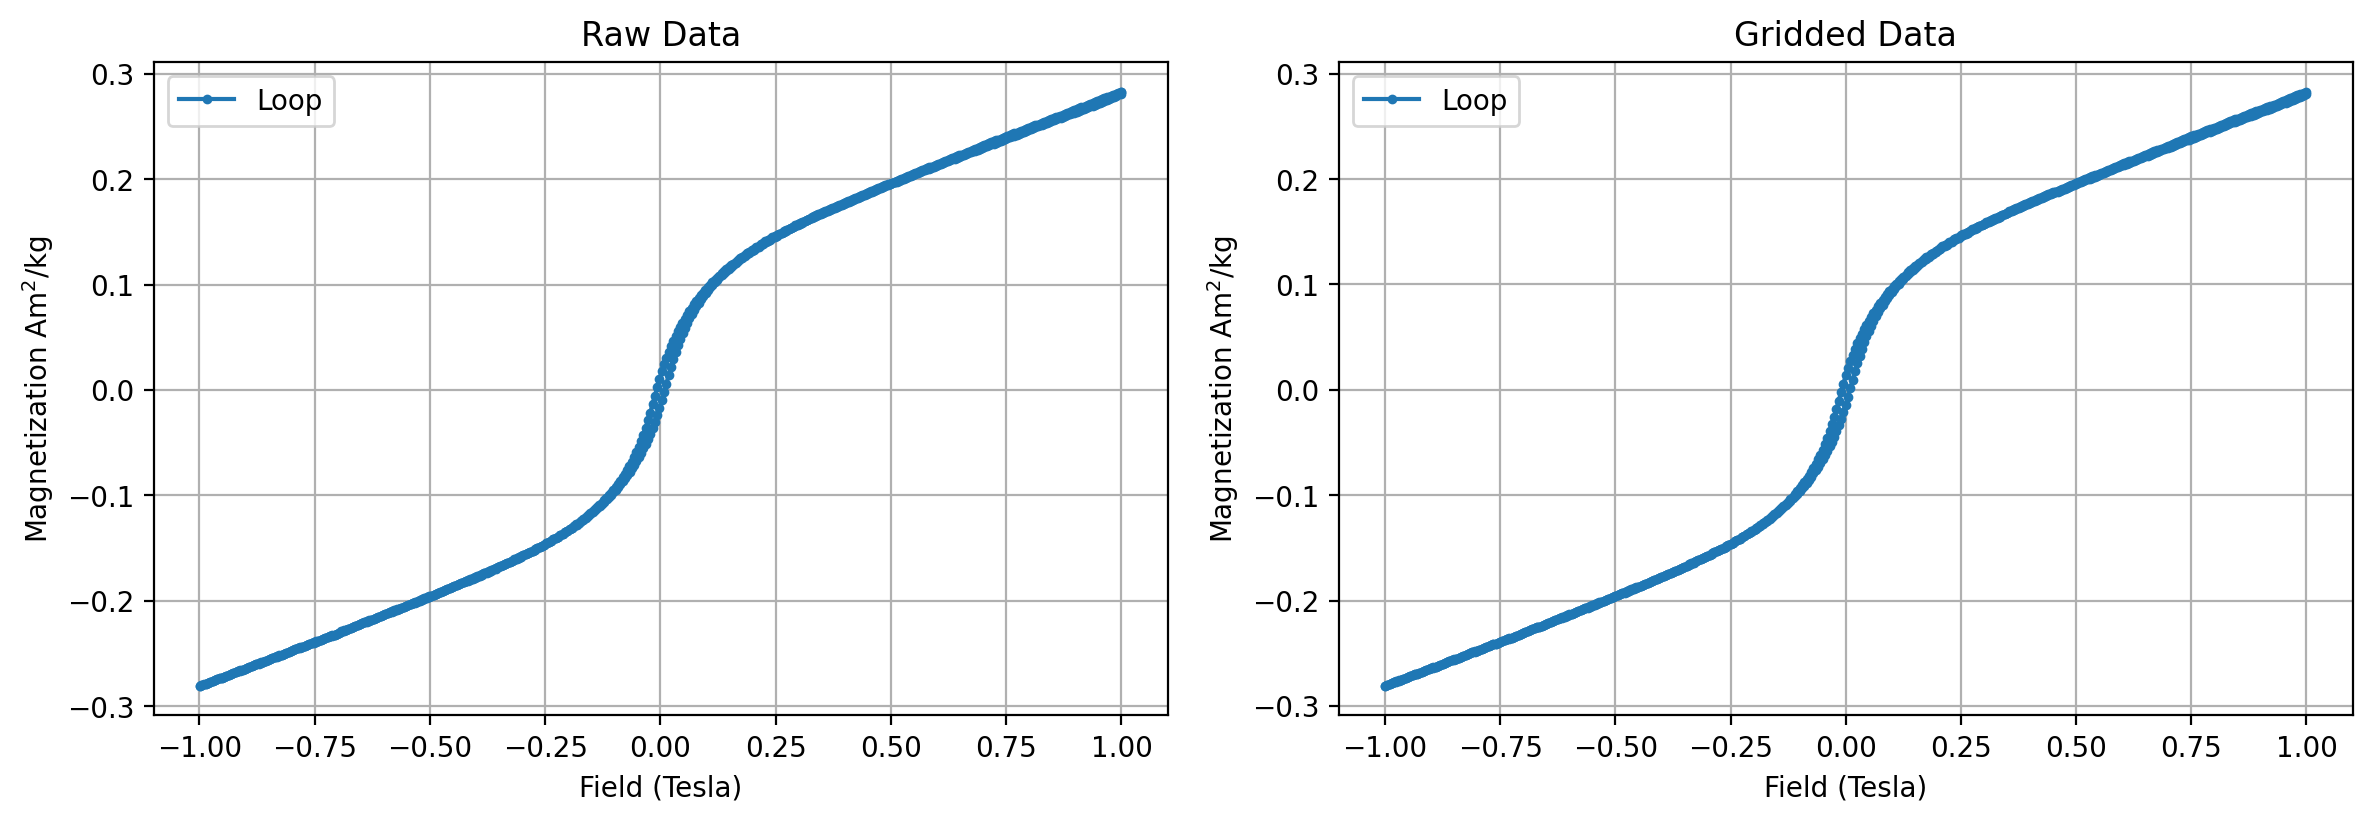

In [16]:
# in matplotlib
g_fig, g_axs = rmag.plot_hyst_data(fields = loop_fields, moments = loop_moments, data_type = data_type, \
                                   return_figure = True, double_plot = True, fields1 = grid_fields, \
                                   moments1 = grid_moments)

# only for matplotlib
g_axs[0].set_title('Raw Data')
g_axs[1].set_title('Gridded Data')
plt.show()

Ideally, these two should be virtually indistinguishable...

### Remanent Hesteretic

Hysteresis loops can be split into reversible and irreversible components. The irreversible component is due to processes like discontinuous domain wall displacement or domain nucleation and extinction and is responsible for the seperation of the loop (von Dobeneck, 1996).

We can calculate the irreversible component by calculating the difference between the upper and lower branch of the hysteresis loop:
$$ M_{rh} = {{M_+ - M_-} \over {2}} $$

In [17]:
moment_sub = rmag.branch_sub(n_loop, grid_moments)

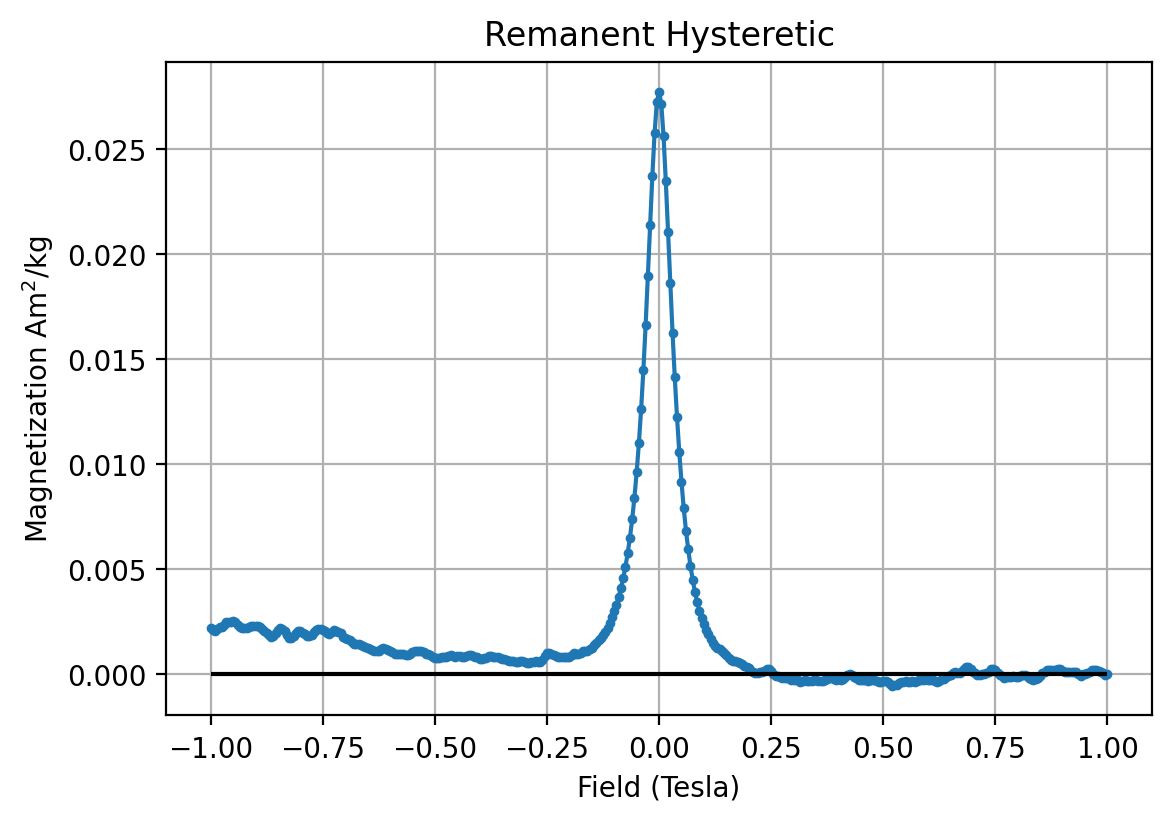

In [18]:
# in matplotlib
Mrh_fig, Mrh_axs = rmag.plot_hyst_data(fields = grid_fields[len(moment_sub):], moments = moment_sub,\
                                   data_type = data_type, return_figure = True)
Mrh_axs.hlines(0, min(grid_fields), max(grid_fields), color = 'k')

# only for matplotlib
Mrh_axs.set_title('Remanent Hysteretic')
Mrh_axs.legend().set_visible(False)
plt.show()

### Testing for nonlinearity

The hysteresis loops of many natural materials can be well approximated by a line because of low concentrations of ferromagnetic materials.

Jackson and Solheid (2010) use the F test to quantify the significance of nonlinearity. This is done by using a least-squares fitting on the entire loop. The total misfit is partitioned into variation due to lack of fit and pure error (random noise). The ratio of these two variences give us $F_{NL}$. If $F_{NL}$ is large, the misfit is mainly due to a lack of fit. For typical loop datasets, linearity can be rejected with 95% confidence for $F_{NL} > 1.25$.

In [19]:
FNL, slope, intercept = rmag.loop_test_linearity(n_loop, grid_fields, grid_moments)
print("FNL = ",FNL)
print("slope = ",slope)
print("intercept = ",intercept)

FNL =  12003.512263839635
slope =  0.33404071265353563
intercept =  3.244968260099771e-05


### Centering the loop

A common assumption made to analyse hysteresis loop data is that the signal has inversion symmetry, with a center slightly offset from the origin. If we recenter the loop, we can use the upper and lower branches of the loop as replicate measurements as each point (B, M) on the upper branch should have a corresponding point (-B, -M) on the lower branch.

To find the horizontal shift ($B_\text{offset}$), the lower branch is inverted through $(B_\text{off}, 0)$. $B_\text{off}$ is varied to find the value at which there is a constant vertical seperation between the upper ($M_+$) and lower ($M_-$) branches. This can be calculated by finding the maximum $R^2$ value for a plots of $M_+(B)$ versus $M_\text{-,inv}(B)$ with a given $B_\text{off}$.

The vertical shift ($M_\text{offset}$) can be determined by finding the intercept of the best fit line through the $M_+(B)$ versus $M_\text{-,inv}(B)$ plot with the highest $R^2$.

In [20]:
M_offset, B_offset, M_sn = rmag.loop_errorcal(n_loop, grid_fields, grid_moments);

print("M_offset = ",M_offset)
print("B_offset = ",B_offset)

M_offset =  0.00013478708007295845
B_offset =  0.0003762891765500765


After the horizontal offset is removed, the remaining deviations in the data should be due to noise and drift. Hence, we can use this to quantify the quality of the data. Here, we will use the quality factor Q, which is the decimal log of the signal to noise ratio.

$$
Q = log_{10}\left(\frac{signal}{noise}\right) = log_{10}\left({\frac{1}{1-R^2}}\right)
$$

High Q values 

In [21]:
Q = rmag.Qfactor(M_sn)
print('Q = ', Q)

Q =  2.8821217544569593


In [22]:
# second call to grid routine removes offsets
grid_fields, grid_moments = rmag.loop_grid(n_loop, polydegree, nsmooth, loop_fields, loop_moments, B_offset, M_offset)
print ("grid_moments = ",grid_moments[0])
print ("grid_fields = ",grid_fields[0])

grid_moments =  0.28256521291992703
grid_fields =  1.0


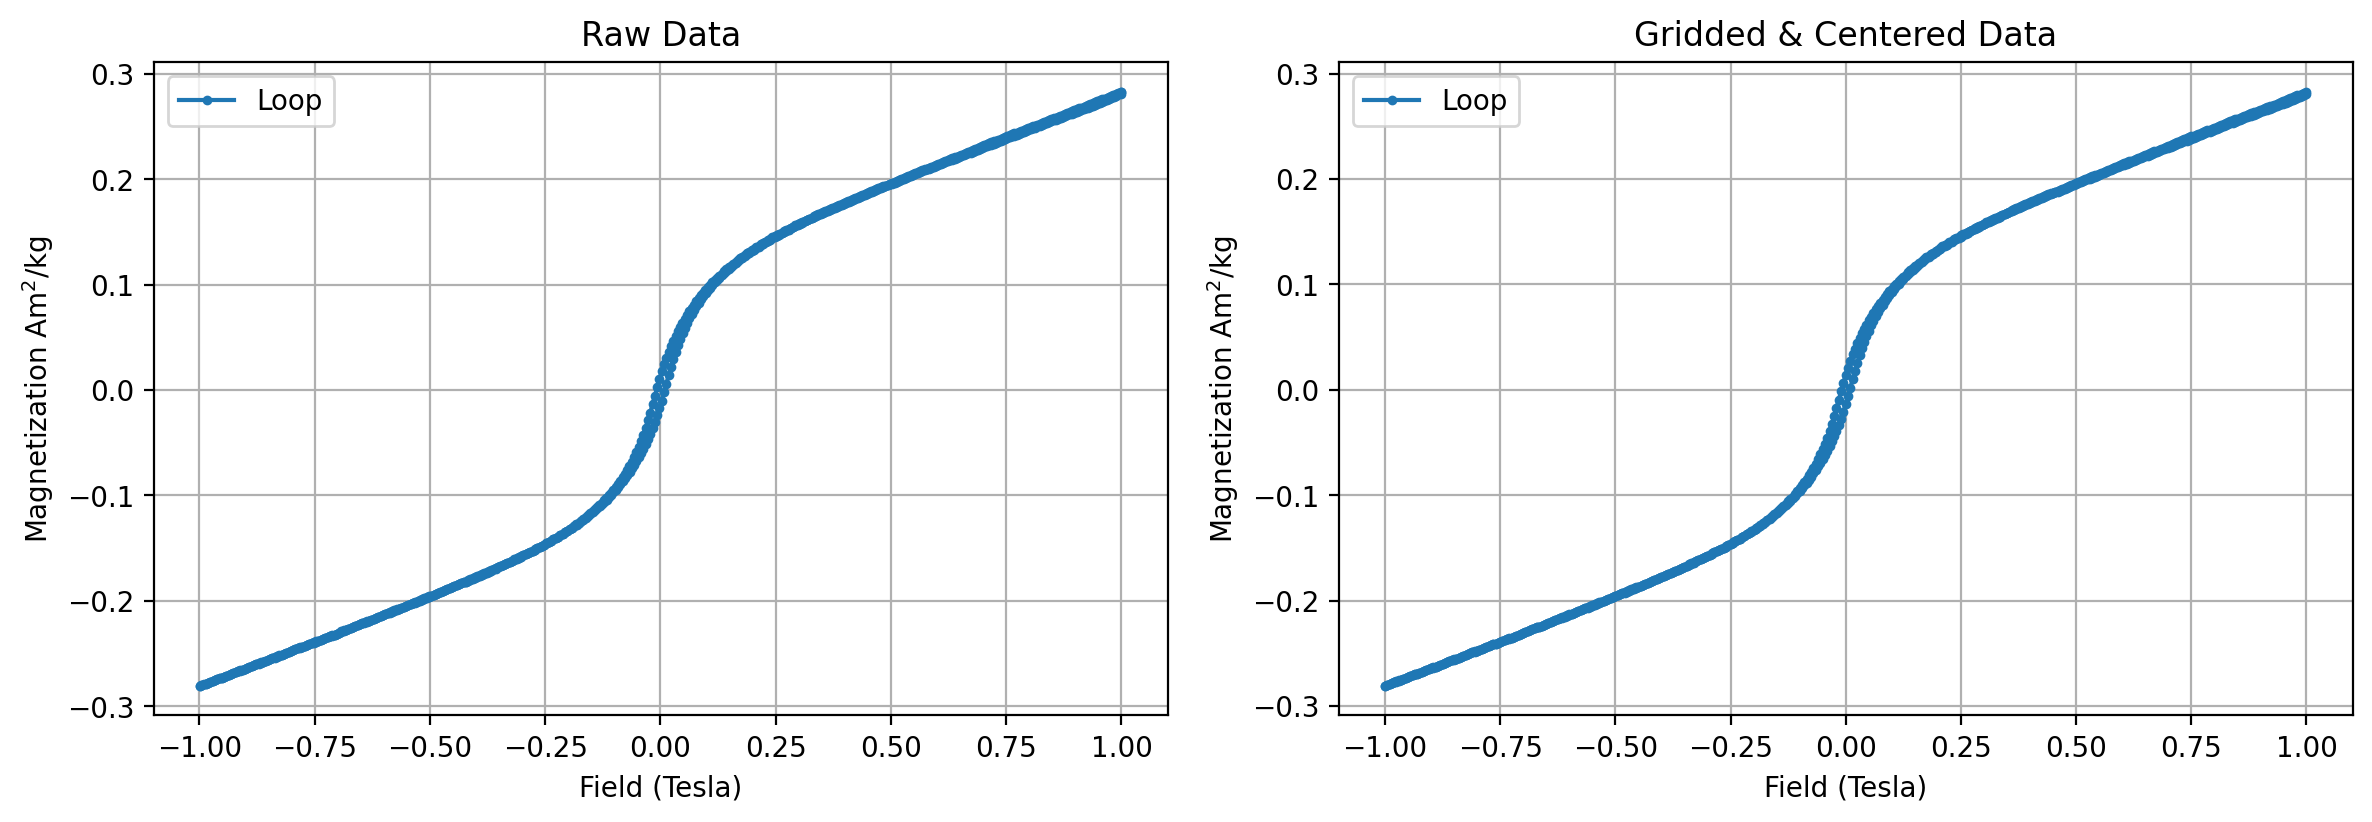

In [24]:
# in matplotlib
g_fig, g_axs = rmag.plot_hyst_data(fields = loop_fields, moments = loop_moments, data_type = data_type, \
                                   return_figure = True, double_plot = True, fields1 = grid_fields, \
                                   moments1 = grid_moments)

# only for matplotlib
g_axs[0].set_title('Raw Data')
g_axs[1].set_title('Gridded & Centered Data')
plt.show()

In [38]:
max(grid_fields)-1

1.5543122344752192e-15

In [31]:
ErrX, ErrY = rmag.loop_errorcal2(n_loop, grid_fields, grid_moments, 0, 0)
for i in range(10):
    print("error x and y = ",ErrX[i],", ",ErrY[i])


M_err = 0
for i in range(0, n_loop//2 -2):
    M_err += (ErrY[i])**2
M_err = math.sqrt(M_err / (n_loop//2 ) )
print("n_loop = ", n_loop//2)
print("M_err = ", M_err)

error x and y =  0.0 ,  0.0
error x and y =  0.995 ,  0.001720777182969313
error x and y =  0.99 ,  0.0016471225457774796
error x and y =  0.985 ,  0.0016792662075232334
error x and y =  0.98 ,  0.001706349540853025
error x and y =  0.975 ,  0.0016318899434113465
error x and y =  0.97 ,  0.001644555777593204
error x and y =  0.965 ,  0.0016318899434164535
error x and y =  0.96 ,  0.0015956690235554571
error x and y =  0.955 ,  0.001531889943411413
n_loop =  401
M_err =  0.0007320004833494539


In [ ]:
mrh, E_hys, Brh, Bih = rmag.loop_delta_M(n_looppoints, grid_fields, grid_moments)
print('loop_delta_m first go')
#print("mrh =", mrh)
print("E_hys =", E_hys)
print("Brh =", Brh)
print("Bih =", Bih)

plt.subplot(1,4,1)
plt.plot(loop_fields, loop_moments)

plt.subplot(1,4,2)
plt.plot(grid_fields, grid_moments)

xpoints = grid_fields[n_loop // 2:]
apoints = grid_fields[n_loop // 2:]
plt.subplot(1,4,3)
ypoints = moment_sub
plt.plot(xpoints, ypoints)

plt.subplot(1,4,4)
zpoints = mrh[:-1]
plt.plot(apoints, zpoints)
plt.show()